<a href="https://www.kaggle.com/code/uniquejie/notebookd1?scriptVersionId=157990974" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

  Obtaining dependency information for mat73 from https://files.pythonhosted.org/packages/d4/c3/123c118e31cd58f5db333ae2750da13da0d87707adac2255357de9bb5f87/mat73-0.62-py3-none-any.whl.metadata
1


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torch/_tensor.py:972: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


epoch: 0, Train Loss J : 45.342553, Train Loss W : 86.834474, Test Loss J : 37.659903, Test Loss W : 2.000817  当前时间戳：4.8
epoch: 1, Train Loss J : 38.351684, Train Loss W : 17.929022, Test Loss J : 38.771176, Test Loss W : 5.903332  当前时间戳：8.9
epoch: 2, Train Loss J : 38.829662, Train Loss W : 16.147802, Test Loss J : 36.120639, Test Loss W : 2.785698  当前时间戳：12.9
epoch: 3, Train Loss J : 37.707655, Train Loss W : 17.793655, Test Loss J : 36.046926, Test Loss W : 2.197214  当前时间戳：16.9
epoch: 4, Train Loss J : 37.391344, Train Loss W : 15.957939, Test Loss J : 35.064113, Test Loss W : 6.293282  当前时间戳：20.9
epoch: 5, Train Loss J : 36.653806, Train Loss W : 16.254576, Test Loss J : 35.216951, Test Loss W : 4.266350  当前时间戳：24.9
epoch: 6, Train Loss J : 37.141221, Train Loss W : 16.676822, Test Loss J : 35.475687, Test Loss W : 2.580729  当前时间戳：28.9
epoch: 7, Train Loss J : 35.955022, Train Loss W : 15.693125, Test Loss J : 33.224861, Test Loss W : 1.256416  当前时间戳：32.9
epoch: 8, Train Loss J : 3

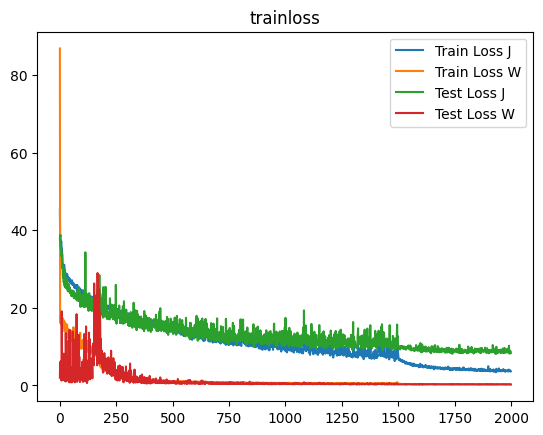

In [1]:
import os
os.chdir('/kaggle/input/learning-code')
!pip install mat73

path = '/kaggle/working/'
files = os.listdir(path)
num_file = len(files)-1
num_file = int((num_file)/3+1)
print(num_file)

import random
from datetime import datetime

import mat73
import torch

from MODEL import *     # 从模型文件中加载定义的网络架构
SeedNumber = 42
random.seed(SeedNumber)
np.random.seed(SeedNumber)
torch.manual_seed(SeedNumber)
# 训练前准备，检测是否有可用的GPU，有则使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data_all
dataMat = mat73.loadmat('/kaggle/input/rader-data/data_all.mat')
signal_train = torch.from_numpy(dataMat['train_signal'])
signal_test = torch.from_numpy(dataMat['test_signal'])

label_train_cd = dataMat['train_cd']
label_train_JW = dataMat['ltrain_JW']
label_test_cd = dataMat['test_cd']
label_test_JW = dataMat['ltest_JW']

# data_200
# dataMat = mat73.loadmat('D:/Pycharm/master/deep_learning/code4/data_200.mat')
# signal_train = torch.from_numpy(dataMat['train_signal_200'])
# signal_test = torch.from_numpy(dataMat['test_signal_200'])
#
# label_train_cd = dataMat['train_cd_200']
# label_train_JW = dataMat['train_label_200']
# label_test_cd = dataMat['test_cd_200']
# label_test_JW = dataMat['test_label_200']

Label_train = torch.from_numpy(label_train_cd)
dH_train = label_train_JW[:, 2]

Label_test = torch.from_numpy(label_test_cd)
dH_test = label_test_JW[:, 2]

Array_num = signal_train.shape[0]
Snap_num = signal_train.shape[1]
Sample_train = signal_train.shape[2]
Sample_test = signal_test.shape[2]

Snap_len = 2000

H = np.zeros((Array_num, Snap_num), dtype=complex)
X_train = np.zeros((Sample_train, 4, Array_num, Array_num), dtype=float)
for Sample_index in range(1, Sample_train + 1):
    H = signal_train[:, 0:Snap_len, Sample_index-1]
    R_temp = 1 / Snap_len * torch.mm(H, torch.adjoint(H))

    X_train[Sample_index - 1, 0, :, :] = torch.real(R_temp)
    X_train[Sample_index - 1, 1, :, :] = torch.imag(R_temp)
    X_train[Sample_index - 1, 2, :, :] = torch.angle(R_temp)
    X_train[Sample_index - 1, 3, :, :] = torch.ones_like(R_temp) * dH_train[Sample_index-1]

X_test = np.zeros((Sample_test, 4, Array_num, Array_num), dtype=float)
for Sample_index in range(1, Sample_test + 1):
    H = signal_test[:, 0:Snap_len, Sample_index-1]
    R_temp = 1 / Snap_len * torch.mm(H, torch.adjoint(H))

    X_test[Sample_index - 1, 0, :, :] = torch.real(R_temp)
    X_test[Sample_index - 1, 1, :, :] = torch.imag(R_temp)
    X_test[Sample_index - 1, 2, :, :] = torch.angle(R_temp)
    X_test[Sample_index - 1, 3, :, :] = torch.ones_like(R_temp) * dH_test[Sample_index-1]


# X[:, Array_num*Array_num] = dH_train

# X_train, X_test, Label_train, Label_test = train_test_split(X, label_train, test_size=0.01)

# scales = MinMaxScaler(feature_range=(0, 1))
# X_train_s = scales.fit_transform(X_train)
# X_test_s = scales.fit_transform(X_test)   # 对数据归一化处理

# 将数据转为张量

X_train_nots = torch.from_numpy(X_train.astype(np.float64)).to(device=device)

Label_train_t = Label_train.to(device=device)

X_test_nots = torch.from_numpy(X_test.astype(np.float64)).to(device=device)

Label_test_t = Label_test.to(device=device)

# 将训练集转化为张量后，使用TensorDataset将输入和标签整理到一起
train_data_nots = TensorDataset(X_train_nots, Label_train_t)
test_data_nots = TensorDataset(X_test_nots, Label_test_t)

##
# 选取网络，定义网络超参数
input_dim = 64
hidden_dim = 20
hidden_layer = 10
out_dim = 1


# Model = LSTM3(input_dim, hidden_dim, hidden_layer, out_dim)   # 选取网络，括号中为输入信号的维度
Model = cnn3()
# Model = net6()
Model.to(device)

# 网络超参数
# 32->64
train_batch_size = 32
test_batch_size = 32
lr = 0.01
num_epoch = 2000
momentum = 0.8
MinTrainLoss = 1e8

# 定义数据加载器，将训练集进行批处理
train_nots_loader = DataLoader(
    dataset=train_data_nots,
    batch_size=train_batch_size,
    shuffle=True,
    drop_last=True
    )
test_nots_loader = DataLoader(
    dataset=test_data_nots,
    batch_size=test_batch_size,
    shuffle=True,
    drop_last=True
)

# 定义损失函数和优化器
Loss = nn.MSELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=lr)

##
# 训练模型

losses_J = []
losses_W = []
acces = []
eval_losses_J = []
eval_losses_W = []
eval_acces = []
losses_all = []

begin = datetime.now().timestamp()

# 写入日志文件
f = open('/kaggle/working/model_iter{}.txt'.format(num_file), 'w')
for epoch in range(num_epoch):
    train_loss_J = 0
    train_loss_W = 0
    # loss1 = 0
    # loss2 = 0
    losses = 0
    train_acc = 0
    Model.train()      # 开始训练
# 动态修改学习率
    if epoch <= 2000 and epoch % 1500 == 0:
        optimizer.param_groups[0]['lr'] *= 0.1
    for step, (b_x, b_y) in enumerate(train_nots_loader):
        # 前向传播
        out = Model(b_x)
        # out = ar2JW(out, b_x[:, 3, 1, 1])
        loss1 = Loss(out[:, 0], b_y[:, 0])
        loss2 = Loss(out[:, 1], b_y[:, 1])
        # loss = (loss1 + loss2)
        loss = loss1 + loss2
        # 反向传播
        optimizer.zero_grad()
        #
        # loss.backward()
        loss.backward()
        # loss2.backward()
        optimizer.step()
        # 记录误差
        train_loss_J += loss1.item()
        train_loss_W += loss2.item()
        losses += loss.item()

        # # 计算分类的准确性
        # _, pred = out.max(1)
        # num_correct = (pred == b_y).sum().item()
        # acc = num_correct / step
        # train_acc += acc

    losses_J.append(train_loss_J / len(train_nots_loader))
    losses_W.append(train_loss_W / len(train_nots_loader))
    losses_all.append(losses)
    # acces.append(train_acc / len((train_nots_loader)))
    
    # 在测试集上验证效果
    eval_loss_J = 0
    eval_loss_W = 0
    eval_acc = 0
    # 模型状态改为测试
    Model.eval()
    for step, (b_x, b_y) in enumerate(test_nots_loader):
        out = Model(b_x)
        # out = ar2JW(out, b_x[:, 3, 1, 1])
        loss1 = Loss(out[:, 0], b_y[:, 0])
        loss2 = Loss(out[:, 1], b_y[:, 1])
        # 记录误差
        eval_loss_J += loss1.item()
        eval_loss_W += loss2.item()
        # # 记录准确率
        # _, pred = out.max(1)
        # num_correct = (pred == b_y).sum().item()
        # acc = num_correct / step
        # eval_acc +=acc
    eval_losses_J.append(eval_loss_J / len(test_nots_loader))
    eval_losses_W.append(eval_loss_W / len(test_nots_loader))
    # eval_acces.append(eval_acc / len(test_nots_loader))

    # 获取时间戳
    str = 'epoch: {}, Train Loss J : {:.6f}, Train Loss W : {:.6f}, Test Loss J : {:.6f}, Test Loss W : {:.6f}'.format\
          (epoch, train_loss_J / len(train_nots_loader), train_loss_W / len(train_nots_loader),
           eval_loss_J / len(test_nots_loader), eval_loss_W / len(test_nots_loader))
    print(str + '  当前时间戳：{:.1f}'.format(datetime.now().timestamp()-begin))
    print(str, file=f)
    ##
    # 保存模型
    if losses_all[-1] < MinTrainLoss:
        torch.save(Model.state_dict(), "/kaggle/working/model_iter{}.pth".format(num_file))  # 保存每一次loss下降的模型
        MinTrainLoss = losses_all[-1]

# 可视化训练及测试损失值
plt.title('trainloss')
plt.plot(np.arange(len(losses_J)), losses_J)
plt.plot(np.arange(len(losses_W)), losses_W)
plt.plot(np.arange(len(eval_losses_J)), eval_losses_J)
plt.plot(np.arange(len(eval_losses_W)), eval_losses_W)
plt.legend(['Train Loss J', 'Train Loss W', 'Test Loss J', 'Test Loss W'], loc='upper right')
# plt.legend(['Test Loss'], loc='upper right')
plt.savefig('/kaggle/working/Test Loss{}.jpg'.format(num_file))

plt.show()